In [3]:
### Package Imports ###
import comet_ml

import tensorflow as tf
import keras
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd


import os
import time
import IPython

import h5py
import mitdeeplearning as mdl

import functools
from tqdm import tqdm

2024-05-30 13:46:09.992424: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-30 13:46:09.992460: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-30 13:46:09.993216: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-30 13:46:09.998149: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Before Running This Notebook:
### Create a .txt file called "comet_key"
### Paste your Comet API Key into comet_key.txt

In [4]:
### Package Setup ###
CWD = os.getcwd()
print(CWD)

key_file = open(f'{CWD}/comet_key.txt')
COMET_API_KEY = key_file.read()
matplotlib.rcParams['font.family'] = "Times New Roman"

current_time = time.localtime(time.time())
print(current_time)

### Create a Comet experiment to track our training run ###
def create_experiment(project_name, params):
    # end any prior experiments
    if 'experiment' in locals():
        experiment.end()

    # initiate the comet experiment for tracking
    experiment = comet_ml.Experiment(
    api_key=COMET_API_KEY,
    project_name=project_name)
    # log our hyperparameters, defined above, to the experiment
    for param, value in params.items():
        experiment.log_parameter(param, value)
    experiment.flush()

    return experiment

### Ensure training on GPU ###
assert len(tf.config.list_physical_devices('GPU')) > 0
assert COMET_API_KEY != "", "Please insert your Comet API Key"
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

/mnt/e/AP Research/Polished-Capstone
time.struct_time(tm_year=2024, tm_mon=5, tm_mday=30, tm_hour=13, tm_min=46, tm_sec=11, tm_wday=3, tm_yday=151, tm_isdst=1)


2024-05-30 13:46:12.035284: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-30 13:46:12.059002: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-30 13:46:12.059040: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.


# Data Loading

In [5]:
### Functions: Load and Visualize Dataset ###

### Function: load dataset ###
@keras.saving.register_keras_serializable(package='capstone',name='load_dataset')
def load_dataset(path_to_training_data):
    with h5py.File(path_to_training_data) as f:
        # Print the keys (names) of all groups and datasets in the file
        print("Keys:", list(f.keys()))

        # Iterate through each key and print more detailed information
        for key in f.keys():
            if isinstance(f[key], h5py.Dataset):
                print(f"Dataset: {key}")
                print("  Shape:", f[key].shape)
                print("  Data type:", f[key].dtype)
                
    ### Instantiate Loader Function ###
    return mdl.lab2.TrainingDatasetLoader(path_to_training_data)

### Function: visualize dataset ###
@keras.saving.register_keras_serializable(package='capstone',name='visualize_dataset')
def visualize_dataset(loader):
    ### Visualize our data ###
    number_of_training_examples = loader.get_train_size()
    print(number_of_training_examples)
    (images, labels) = loader.get_batch(100)
    malignant_images = images[np.where(labels==1)[0]]
    benign_images = images[np.where(labels==0)[0]]

    idx_malignant = 23
    idx_benign = 9

    plt.figure(figsize=(5,5))
    plt.subplot(1, 2, 1)
    plt.imshow(malignant_images[idx_malignant])
    plt.title("Malignant"); plt.grid(False)

    plt.subplot(1, 2, 2)
    plt.imshow(benign_images[idx_benign])
    plt.title("Benign"); plt.grid(False)

In [6]:
### Instantiate Loaders: train/val 90/10 ###
loader_ISIC = load_dataset(f'{CWD}/datasets/split-90train-10val/train_ISIC.h5')
loader_ISIC_DiDI = load_dataset(f'{CWD}/datasets/split-90train-10val/train_ISIC_DiDI.h5')
loader_ISIC_ArGI = load_dataset(f'{CWD}/datasets/split-90train-10val/train_ISIC_ArGI.h5')

loader_val_ISIC = load_dataset(f'{CWD}/datasets/split-90train-10val/val_ISIC.h5')
loader_val_ISIC_DiDI = load_dataset(f'{CWD}/datasets/split-90train-10val/val_ISIC_DiDI.h5')
loader_val_ISIC_ArGI =  load_dataset(f'{CWD}/datasets/split-90train-10val/val_ISIC_ArGI.h5')

Keys: ['images', 'labels']
Dataset: images
  Shape: (1778, 64, 64, 3)
  Data type: uint8
Dataset: labels
  Shape: (1778, 1)
  Data type: float64
Opening /mnt/e/AP Research/Polished-Capstone/datasets/split-90train-10val/train_ISIC.h5
Loading data into memory...


Keys: ['images', 'labels']
Dataset: images
  Shape: (2368, 64, 64, 3)
  Data type: uint8
Dataset: labels
  Shape: (2368, 1)
  Data type: float64
Opening /mnt/e/AP Research/Polished-Capstone/datasets/split-90train-10val/train_ISIC_DiDI.h5
Loading data into memory...
Keys: ['images', 'labels']
Dataset: images
  Shape: (2368, 64, 64, 3)
  Data type: uint8
Dataset: labels
  Shape: (2368, 1)
  Data type: float64
Opening /mnt/e/AP Research/Polished-Capstone/datasets/split-90train-10val/train_ISIC_ArGI.h5
Loading data into memory...
Keys: ['images', 'labels']
Dataset: images
  Shape: (198, 64, 64, 3)
  Data type: uint8
Dataset: labels
  Shape: (198, 1)
  Data type: float64
Opening /mnt/e/AP Research/Polished-Capstone/datasets/split-90train-10val/val_ISIC.h5
Loading data into memory...
Keys: ['images', 'labels']
Dataset: images
  Shape: (264, 64, 64, 3)
  Data type: uint8
Dataset: labels
  Shape: (264, 1)
  Data type: float64
Opening /mnt/e/AP Research/Polished-Capstone/datasets/split-90train-

In [7]:
# ### Visualize Training Datasets ###
# visualize_dataset(loader_ISIC)
# visualize_dataset(loader_ISIC_DiDI)
# visualize_dataset(loader_ISIC_ArGI)

# Create Model Architectures

In [8]:
### Standard CNN ###

# Helper Functions

@keras.saving.register_keras_serializable(package='capstone', name='resize_images')
def resize_images(x):
    return tf.image.resize(x, (64, 64))

# CNN Function
@keras.saving.register_keras_serializable(package='capstone', name='make_standard_ResNet50_V2')
def make_standard_ResNet50_V2(n_outputs = 1):
    
    Resize = tf.keras.layers.Lambda(resize_images)
    Flatten = tf.keras.layers.Flatten
    Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
    ResNet50V2 = tf.keras.applications.ResNet50V2(
        include_top=False,
        weights="imagenet", # Utilizing Transfer Learning, also maintains consistency
        input_tensor=None,
        input_shape=(64,64,3),
        pooling=None,
        classes=1000,
        classifier_activation="softmax",
    )
    ResNet50V2 = tf.keras.Model(inputs = ResNet50V2.layers[1].input, 
                                outputs = ResNet50V2.layers[-1].output)

    model = tf.keras.Sequential()
    
    model.add(Resize)
    model.add(ResNet50V2)
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Dense(n_outputs, activation=None))

    return model

In [9]:
### DB-VAE ###

### Define Decoder Network ###
@keras.saving.register_keras_serializable(package='capstone', name='make_decoder_network')
def make_decoder_network(latent_dim = 100, n_filters = 12 ):
    """
    Layer Types, Functional Definition
    """
    Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, padding='same', activation='relu')
    Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
    Reshape = tf.keras.layers.Reshape 
    BatchNormalization = tf.keras.layers.BatchNormalization
    LeakyReLU = tf.keras.layers.LeakyReLU
    # Decoder
    decoder = tf.keras.Sequential([
        Dense(units=4*4*6*n_filters),
        Reshape(target_shape=(4,4,6*n_filters)),

        Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),

        Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),

        Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),

        Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', activation='sigmoid')
    ])
    
    return decoder

### DB_VAE Helper Functions ###


### VAE Reparameterization ###
@keras.saving.register_keras_serializable(package='capstone', name='sampling_VAE_reparameterization')
def sampling(z_mean, z_logsigma):
    batch, latent_dim = z_mean.shape
    epsilon = tf.random.normal(shape=(batch, latent_dim))
    z = z_mean + tf.math.exp(0.5 * z_logsigma) * epsilon
    return z

### Defining the VAE loss function ###
@keras.saving.register_keras_serializable(package='capstone', name='vae_loss_function')
def vae_loss_function(x, x_recon, mu, logsigma, kl_weight=0.0005):
  latent_loss = 0.5 * tf.reduce_sum(tf.exp(logsigma) + tf.square(mu) - 1.0 - logsigma, axis=1)
  reconstruction_loss = tf.reduce_mean(tf.abs(x-x_recon), axis=(1,2,3))
  vae_loss = kl_weight * latent_loss + reconstruction_loss
  return vae_loss

### Loss function for DB-VAE ###
@keras.saving.register_keras_serializable(package='capstone',name='debiasing_loss_function')
def debiasing_loss_function(x, x_pred, y, y_logit, mu, logsigma):
  vae_loss = vae_loss_function(x, x_pred, mu, logsigma)
  classification_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_logit)
  malignance_indicator = tf.cast(tf.equal(y, 1), tf.float32)
  total_loss = tf.reduce_mean(
      classification_loss +
      malignance_indicator * vae_loss
  )
  return total_loss, classification_loss

### Defining and creating the DB-VAE ###
@keras.saving.register_keras_serializable(package='capstone')
class DB_VAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(DB_VAE, self).__init__()
    self.latent_dim = latent_dim

    # Define the number of outputs for the encoder. Recall that we have
    # `latent_dim` latent variables, as well as a supervised output for the
    # classification.
    num_encoder_dims = 2*self.latent_dim + 1

    self.encoder = make_standard_ResNet50_V2(num_encoder_dims)
    self.decoder = make_decoder_network()

  def encode(self, x):
    encoder_output = self.encoder(x)
    y_logit = tf.expand_dims(encoder_output[:, 0], -1)
    z_mean = encoder_output[:, 1:self.latent_dim+1]
    z_logsigma = encoder_output[:, self.latent_dim+1:]

    return y_logit, z_mean, z_logsigma

  def reparameterize(self, z_mean, z_logsigma):
    z = sampling(z_mean, z_logsigma)
    return z

  def decode(self, z):
    reconstruction = self.decoder(z)
    return reconstruction

  def call(self, x):
    y_logit, z_mean, z_logsigma = self.encode(x)
    z = self.reparameterize(z_mean, z_logsigma)
    recon = self.decode(z)
    return y_logit, z_mean, z_logsigma, recon

  def predict(self, x):
    y_logit, z_mean, z_logsigma = self.encode(x)
    return y_logit
  
### DB_VAE Training Helper Functions ###

# Function to return the means for an input image batch
@keras.saving.register_keras_serializable(package='capstone',name='get_latent_mu')
def get_latent_mu(images, dbvae, batch_size=1024, latent_dim=100):
    N = images.shape[0]
    mu = np.zeros((N, latent_dim))
    for start_ind in range(0, N, batch_size):
        end_ind = min(start_ind+batch_size, N+1)
        batch = (images[start_ind:end_ind]).astype(np.float32)/255.
        _, batch_mu, _ = dbvae.encode(batch)
        mu[start_ind:end_ind] = batch_mu
    return mu

@keras.saving.register_keras_serializable(package='capstone',name='get_training_sample_probabilities')
def get_training_sample_probabilities(images, dbvae, bins=10, smoothing_fac=0.001, latent_dim=100):
    print("Recomputing the sampling probabilities")
    mu = get_latent_mu(images, dbvae)
    training_sample_p = np.zeros(mu.shape[0])
    for i in range(latent_dim):
        latent_distribution = mu[:,i]
        hist_density, bin_edges =  np.histogram(latent_distribution, density=True, bins=bins)
        bin_edges[0] = -float('inf')
        bin_edges[-1] = float('inf')
        bin_idx = np.digitize(latent_distribution, bin_edges)
        hist_smoothed_density = hist_density + smoothing_fac
        hist_smoothed_density = hist_smoothed_density / np.sum(hist_smoothed_density)
        p = 1.0/(hist_smoothed_density[bin_idx-1])
        p = p / np.sum(p)
        training_sample_p = np.maximum(p, training_sample_p)
    training_sample_p /= np.sum(training_sample_p)

    return training_sample_p

In [10]:
### Set Training Hyperparameters ###

### Hyperparameters for CNN Training ###
params_CNN = dict( 
  batch_size = 32,
  num_epochs = 20,
  learning_rate = 1e-3, # 5e-4 was the old rate
  min_lr = 1e-5, # for adaptive learning rate
  factor = 0.5, # for adaptive learning rate
  patience_lr = 5, # for adaptive learning rate
  patience_stop = 15, # for early stopping
)

### Hyperparameters for DB-VAE Training ###
params_DB_VAE = dict(
    batch_size = 32,
    num_epochs = 50, 
    learning_rate = 5e-4,
    latent_dim = 100,
)

# Training

In [11]:
### Start Base CNN Experiment ###
@keras.saving.register_keras_serializable(package='capstone',name='experiment_base_CNN')
def experiment_base_CNN(model_num, data_loader, params, validation_loader):

    ### Instantiate new model ###
    model = make_standard_ResNet50_V2()

    ### Train the standard CNN ###
    experiment = create_experiment(f"{current_time.tm_year}-{current_time.tm_mon}-{current_time.tm_mday}_Model_{model_num}", params)  

    optimizer = tf.keras.optimizers.Adam(params["learning_rate"]) # define our optimizer
    # print(optimizer.lr)
    # optimizer.lr = learning_rate
    # print(optimizer.lr)
    

    loss_history = mdl.util.LossHistory(smoothing_factor=0.99) # to record loss evolution
    plotter = mdl.util.PeriodicPlotter(sec=2, scale='semilogy')
    if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    train_loss_metric = tf.keras.metrics.SparseCategoricalCrossentropy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_loss_metric = tf.keras.metrics.SparseCategoricalCrossentropy()

    @tf.function
    def standard_train_step(x, y):
        with tf.GradientTape() as tape:
            # feed the images into the model
            logits = model(x)
            # Compute the loss
            loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)

        # Backpropagation
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        train_acc_metric.update_state(y, logits)
        train_loss_metric.update_state(y, logits)

        return loss

    @tf.function
    def test_step(x,y):
        logits = model(x, training=False)
        val_acc_metric.update_state(y, logits)
        val_loss_metric.update_state(y, logits)

    # The training loop!

    # for early stopping
    wait_val_loss = 0
    best_val_loss = float('inf')

    # for adaptive learning rate
    wait_val_acc = 0
    best_val_acc = float(0)

    step = 0 
    completed_epochs = 0 

    for epoch in range(params["num_epochs"]):

        print("\nStart of epoch %d" % (epoch,))
        start_time = time.time()

        # Training
        for idx in tqdm(range(data_loader.get_train_size()//params["batch_size"])):
            # Grab a batch of training data and propagate through the network
            x, y = data_loader.get_batch(params["batch_size"])

            loss = standard_train_step(x, y)

            # Record the loss and plot the evolution of the loss as a function of training
            loss_history.append(loss.numpy().mean())
            plotter.plot(loss_history.get())

            experiment.log_metric("loss", loss.numpy().mean(), step=step)
            step += 1

        train_acc = train_acc_metric.result()
        train_loss = train_loss_metric.result()
        train_acc_metric.reset_states()
        train_loss_metric.reset_states()
        print("Training acc over epoch: %.4f" % (train_acc.numpy()))

        # Validation
        for idx in tqdm(range(validation_loader.get_train_size()//params['batch_size'])):
            x, y = validation_loader.get_batch(params['batch_size'])
            test_step(x, y)

        val_acc = val_acc_metric.result()
        val_loss = val_loss_metric.result()
        val_acc_metric.reset_states()
        val_loss_metric.reset_states()
        print("Validation acc: %.4f" % (float(val_acc),))
        print("Time taken: %.2fs" % (time.time() - start_time))

        # adjust learning rate
        wait_val_acc += 1
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            wait_val_acc = 0
        if wait_val_acc >= params['patience_lr']:
            if (optimizer.lr != params['min_lr']): # if the optimizer isn't at minimum LR
                print("learning rate changed")
                old_lr = optimizer.lr
                optimizer.lr = old_lr * params['factor'] # multiply optimizer LR by factor
                new_lr = optimizer.lr
                assert abs(old_lr - new_lr) < 1e-9 # ensure the rate actually did change
                # I set the tolerance to 1e-9; that's way below the min LR.

        # check for early stopping
        completed_epochs += 1
        wait_val_loss += 1
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            wait_val_loss = 0
        if wait_val_loss >= params['patience_stop']:
            print("EARLY STOP")
            break


    ### Obtain Loss Values Over Epoch ###
    steps = len(loss_history.get())
    print(steps)

    epochs = np.uint8(completed_epochs)
    batches_per_epoch = np.uint8(steps/epochs)

    loss_hist = np.zeros((steps,1))
    for i in range(steps):
        loss_hist[i] = loss_history.get()[i]
    print([epochs, batches_per_epoch])
    print(f'Loss_hist: {loss_hist.shape}')

    loss_hist = loss_hist.reshape(epochs, batches_per_epoch)

    row_means = np.zeros((epochs))
    for i in range(epochs):
        row_means[i] = loss_hist.sum(axis=1)[i]

    row_means = row_means/batches_per_epoch
    for mean in row_means:
        print(mean)

    experiment.end()
    return model, row_means, completed_epochs

In [12]:
### Start DB-VAE Experiment ###
@keras.saving.register_keras_serializable(package='capstone',name='experiment_DB_VAE')
def experiment_DB_VAE(model_num, data_loader, params):
    
    ### Instantiate new model ###
    model = DB_VAE(params["latent_dim"])
    
    experiment = create_experiment(f"{current_time.tm_year}-{current_time.tm_mon}-{current_time.tm_mday}_Model_{model_num}", params)

    optimizer = tf.keras.optimizers.Adam(params["learning_rate"])

    @tf.function
    def debiasing_train_step(x, y):
        with tf.GradientTape() as tape:
            y_logit, z_mean, z_logsigma, x_recon = model(x)
            loss, class_loss = debiasing_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        return loss

    all_imgs = data_loader.get_all_train_faces()

    if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

    loss_history_2 = mdl.util.LossHistory(smoothing_factor=0.99) # to record loss evolution
    # The training loop -- outer loop iterates over the number of epochs
    step = 0
    for i in range(params["num_epochs"]):

        IPython.display.clear_output(wait=True)
        print("Starting epoch {}/{}".format(i+1, params["num_epochs"]))
        p_lesions = get_training_sample_probabilities(all_imgs, model)

        for j in tqdm(range(data_loader.get_train_size() // params["batch_size"])):
            # load a batch of data
            (x, y) = data_loader.get_batch(params["batch_size"], p_pos=p_lesions)

            # loss optimization
            loss = debiasing_train_step(x, y)
            experiment.log_metric("loss", loss.numpy().mean(), step=step, epoch=i+1)
            loss_history_2.append(loss.numpy().mean())
            # plot the progress every 200 steps
            if j % 500 == 0:
                mdl.util.plot_sample(x, y, model)

            step += 1

    ### Obtain Loss Values Over Epoch ###
    steps = len(loss_history_2.get())
    print(steps)

    epochs = np.uint8(params['num_epochs'])
    batches_per_epoch = np.uint8(steps/epochs)

    loss_hist = np.zeros((steps,1))
    for i in range(steps):
        loss_hist[i] = loss_history_2.get()[i]
    loss_hist = loss_hist.reshape(epochs, batches_per_epoch)

    row_means = np.zeros((epochs))
    for i in range(epochs):
        row_means[i] = loss_hist.sum(axis=1)[i]

    row_means = row_means/batches_per_epoch
    for mean in row_means:
        print(mean)

    experiment.end()

    return model, row_means

In [13]:
@keras.saving.register_keras_serializable(package='capstone',name='graph_loss')
def graph_loss(model_num, row_means, epochs, savepath):
    epochs_range = np.arange(1,epochs+1)
    plt.figure(figsize=(8,7))
    size_axis_titles = 16
    size_title = 18
    size_legend = 14
    plt.xlabel("Epoch", fontsize=size_axis_titles)
    plt.ylabel("Loss", fontsize=size_axis_titles)
    plt.axis([1, 50, 0, 2.5])
    plt.plot(epochs_range, row_means, label='Training')
    plt.legend(loc='upper right', fontsize=size_legend)
    plt.title(f'Training Loss for Model {model_num}', fontsize=size_title)

    plt.savefig(f'{savepath}.png', bbox_inches='tight')

    plt.show()

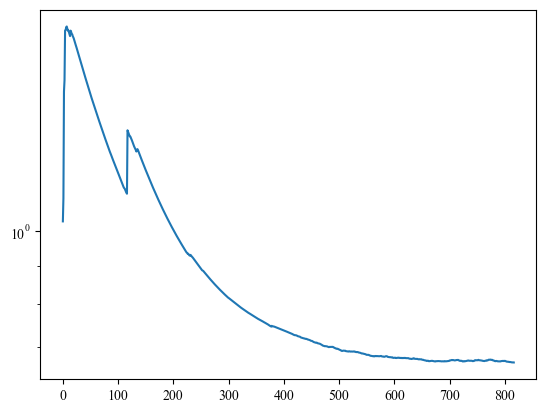

100%|██████████| 55/55 [00:04<00:00, 11.70it/s]


Training acc over epoch: 0.5000


100%|██████████| 6/6 [00:00<00:00, 58.98it/s]
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/88mangos/2024-5-30-model-1/3613ae7fd7104bdc95f6505cf556d4ee
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [825] : (0.567469596862793, 44.1722412109375)
COMET INFO:   Parameters:
COMET INFO:     Adam_amsgrad                 : False
COMET INFO:     Adam_beta_1                  : 0.9
COMET INFO:     Adam_beta_2                  : 0.999
COMET INFO:     Adam_clipnorm                : None
COMET INFO:     Adam_clipvalue               : None
COMET INFO:     Adam_ema_momentum            : 0.99
COMET INFO:     Adam_ema_overwrite_frequency : None
COMET INFO:     Adam_epsilon  

Validation acc: 0.5000
Time taken: 4.82s
learning rate changed
EARLY STOP
825
[15, 55]
Loss_hist: (825, 1)
1.679990831493486
1.3047487149391943
1.2376517679094532
1.0351566786105872
0.8985564532306686
0.8143138308922241
0.7621323477581508
0.7312053840529718
0.7070550342245978
0.6908423997986878
0.6806156503313768
0.6757163704157585
0.6713889432406692
0.6717932337065214
0.6703824279282009


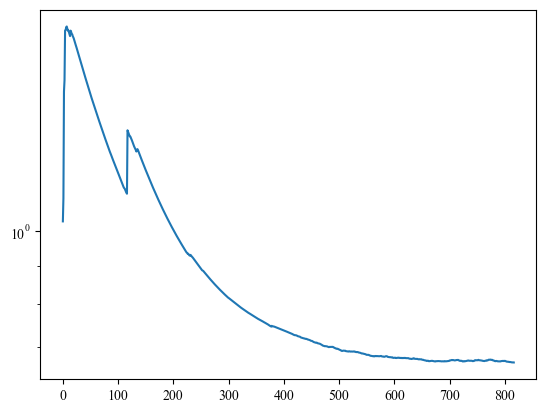

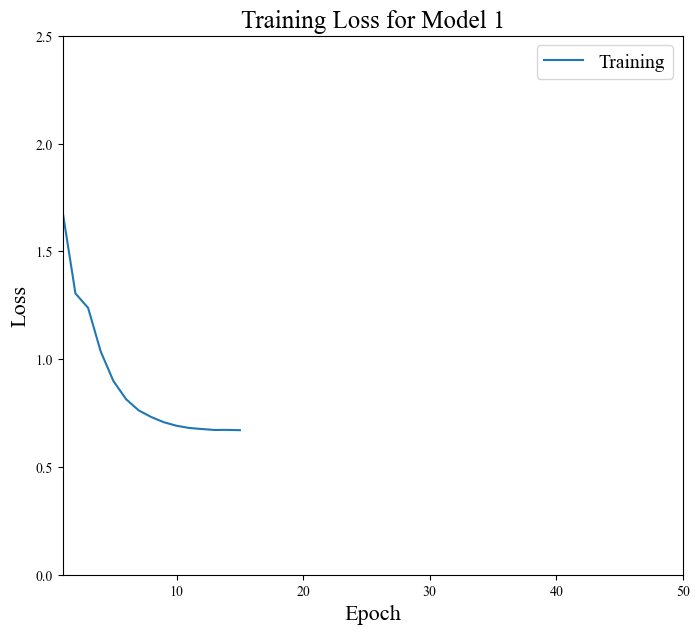

In [14]:
model_1, row_means_1, completed_epochs = experiment_base_CNN(1, loader_ISIC, params_CNN, loader_val_ISIC)
graph_loss(1, row_means_1, completed_epochs, f"{CWD}/models/{current_time.tm_year}-{current_time.tm_mon}-{current_time.tm_mday}_model_{1}_training_loss")
model_1.save(f"{CWD}/models/{current_time.tm_year}-{current_time.tm_mon}-{current_time.tm_mday}_model_{1}.keras")
tf.keras.backend.clear_session()

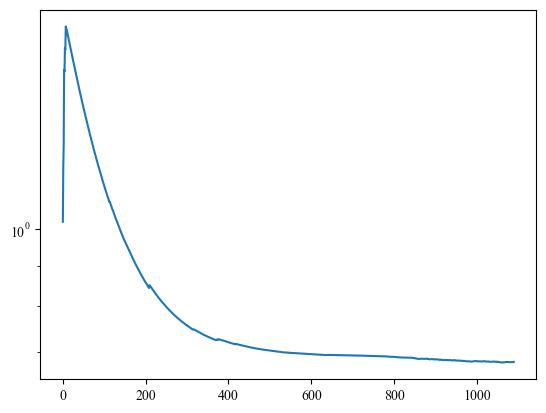

100%|██████████| 74/74 [00:06<00:00, 11.97it/s]


Training acc over epoch: 0.5000


100%|██████████| 8/8 [00:00<00:00, 51.53it/s]
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/88mangos/2024-5-30-model-2/1ada6e60c0744b298afcc91415bede12
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [1110] : (0.6088218688964844, 32.225154876708984)
COMET INFO:   Parameters:
COMET INFO:     Adam_amsgrad                 : False
COMET INFO:     Adam_beta_1                  : 0.9
COMET INFO:     Adam_beta_2                  : 0.999
COMET INFO:     Adam_clipnorm                : None
COMET INFO:     Adam_clipvalue               : None
COMET INFO:     Adam_ema_momentum            : 0.99
COMET INFO:     Adam_ema_overwrite_frequency : None
COMET INFO:     Adam_epsil

Validation acc: 0.5000
Time taken: 6.35s
learning rate changed
EARLY STOP
1110
[15, 74]
Loss_hist: (1110, 1)
1.5025430006012988
1.1003791058311274
0.8909907561408322
0.7918487003363951
0.7407417015124919
0.7196948939291659
0.7063551349688303
0.699006170463436
0.6954127843995508
0.6938302359323391
0.6918704867197405
0.6882893798346781
0.6848849214722524
0.6821964870667616
0.6802285757451169


TypeError: graph_loss() missing 1 required positional argument: 'savepath'

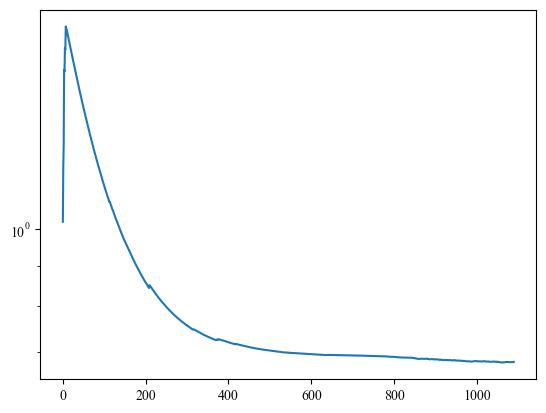

In [15]:
model_2, row_means_2, completed_epochs = experiment_base_CNN(2, loader_ISIC_DiDI, params_CNN, loader_val_ISIC_DiDI)
graph_loss(2, row_means_2, completed_epochs,  f"{CWD}/models/{current_time.tm_year}-{current_time.tm_mon}-{current_time.tm_mday}_model_{2}_training_loss")
model_2.save(f"{CWD}/models/{current_time.tm_year}-{current_time.tm_mon}-{current_time.tm_mday}_model_{2}.keras")
tf.keras.backend.clear_session()

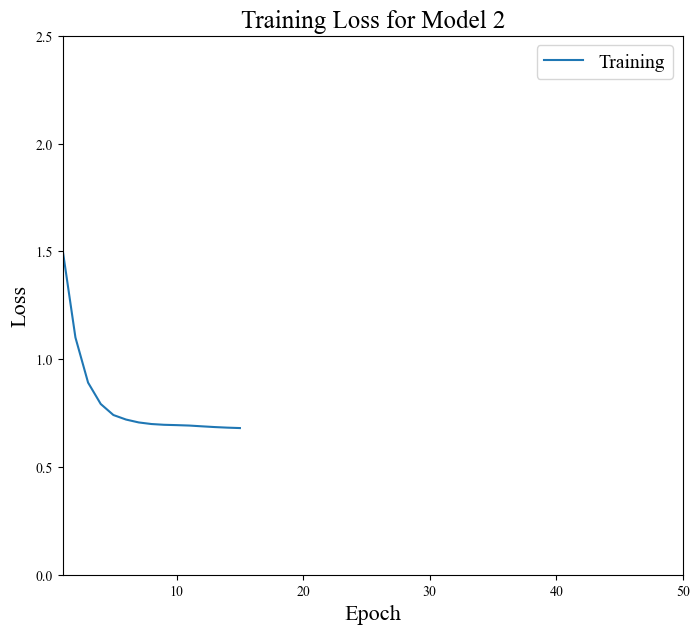

In [16]:
graph_loss(2, row_means_2, completed_epochs,  f"{CWD}/models/{current_time.tm_year}-{current_time.tm_mon}-{current_time.tm_mday}_model_{2}_training_loss")
model_2.save(f"{CWD}/models/{current_time.tm_year}-{current_time.tm_mon}-{current_time.tm_mday}_model_{2}.keras")
tf.keras.backend.clear_session()

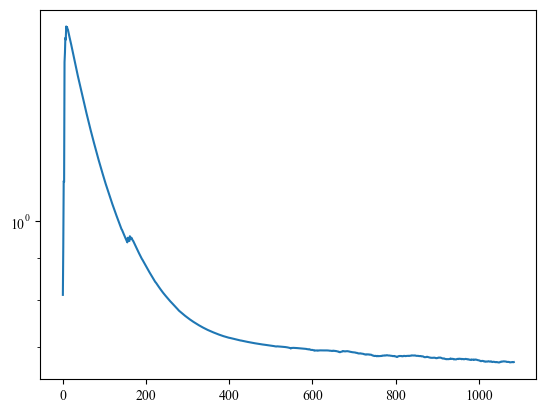

100%|██████████| 74/74 [00:06<00:00, 12.03it/s]


Training acc over epoch: 0.5000


100%|██████████| 8/8 [00:00<00:00, 54.25it/s]
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/88mangos/2024-5-30-model-3/ff5a81cc05424289a72a3a903e8996a4
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [1110] : (0.6018557548522949, 46.326656341552734)
COMET INFO:   Parameters:
COMET INFO:     Adam_amsgrad                 : False
COMET INFO:     Adam_beta_1                  : 0.9
COMET INFO:     Adam_beta_2                  : 0.999
COMET INFO:     Adam_clipnorm                : None
COMET INFO:     Adam_clipvalue               : None
COMET INFO:     Adam_ema_momentum            : 0.99
COMET INFO:     Adam_ema_overwrite_frequency : None
COMET INFO:     Adam_epsil

Validation acc: 0.5000
Time taken: 6.32s
learning rate changed
EARLY STOP
1110
[15, 74]
Loss_hist: (1110, 1)
1.467318453264718
1.0899256211486164
0.9078244191236446
0.7983860313342112
0.7426375791391113
0.7172672639025899
0.7049102579736759
0.698051327701856
0.692686164868169
0.688438797367141
0.6824018878519577
0.6815613177560718
0.6771094462107332
0.6736434243471855
0.6706539382133053


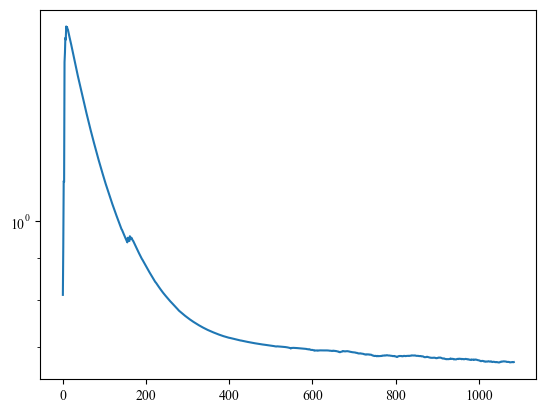

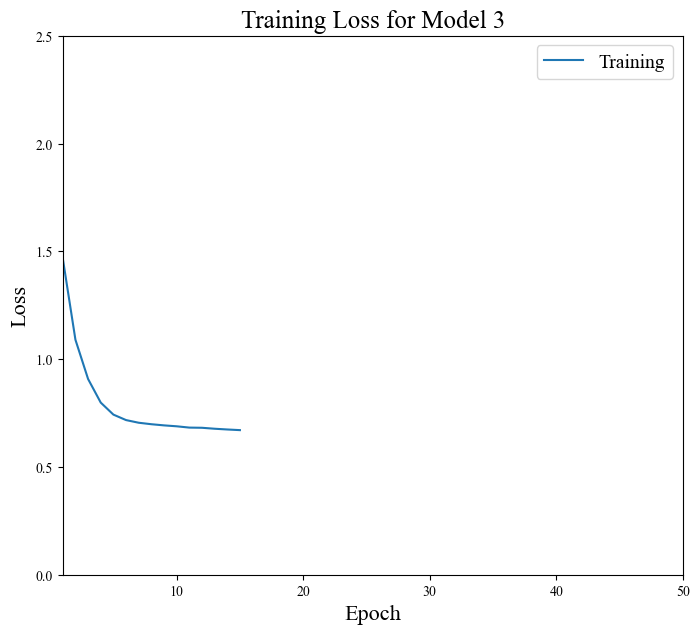

In [17]:
model_3, row_means_3, completed_epochs = experiment_base_CNN(3, loader_ISIC_ArGI, params_CNN, loader_val_ISIC_ArGI)
graph_loss(3, row_means_3, completed_epochs, f"{CWD}/models/{current_time.tm_year}-{current_time.tm_mon}-{current_time.tm_mday}_model_{3}_training_loss")
model_3.save(f"{CWD}/models/{current_time.tm_year}-{current_time.tm_mon}-{current_time.tm_mday}_model_{3}.keras")
tf.keras.backend.clear_session()

Starting epoch 50/50
Recomputing the sampling probabilities


  0%|          | 0/55 [00:00<?, ?it/s]

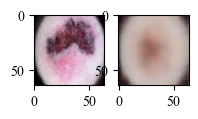

100%|██████████| 55/55 [00:04<00:00, 11.83it/s]
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/88mangos/2024-5-30-model-4/e5ced43edf284b0f8acfca9755350566
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [2750] : (0.049571387469768524, 5.953476905822754)
COMET INFO:   Parameters:
COMET INFO:     Adam_amsgrad                 : False
COMET INFO:     Adam_beta_1                  : 0.9
COMET INFO:     Adam_beta_2                  : 0.999
COMET INFO:     Adam_clipnorm                : None
COMET INFO:     Adam_clipvalue               : None
COMET INFO:     Adam_ema_momentum            : 0.99
COMET INFO:     Adam_ema_overwrite_frequency : None
COMET INFO:     Adam_ep

2750
1.127742708491443
0.9729271981293612
0.8468638395408533
0.7445557690766108
0.6733655201034698
0.6338438421857283
0.6040239192759996
0.5774449052833055
0.541717684148517
0.511830296420283
0.49829050805120073
0.47790321133429237
0.4473459981682982
0.4113240670422046
0.38558941488364507
0.35928440388697896
0.3347369274706065
0.3103450095762136
0.2906919933174539
0.2786692069046117
0.25831661949803203
0.2452795181634045
0.22938769708490697
0.20486666995154434
0.18644049741585467
0.1646597022197171
0.15325922284044954
0.1462559190835262
0.1449857915146942
0.13793261156525136
0.13811641084156331
0.1279805999257878
0.12486216601697833
0.12600596201448164
0.12671122445639363
0.12120589312724471
0.11731024575352922
0.11778514588620884
0.11588627350973336
0.11474044174609281
0.12088517853689626
0.11449649782526311
0.11358309217153785
0.10778936760030884
0.09380421641953496
0.0925917691725545
0.09399917251385256
0.09619274759416258
0.10232608925720604
0.10025574701534237


COMET INFO: Please wait for metadata to finish uploading (timeout is 3600 seconds)
COMET INFO: Uploading 284 metrics, params and output messages


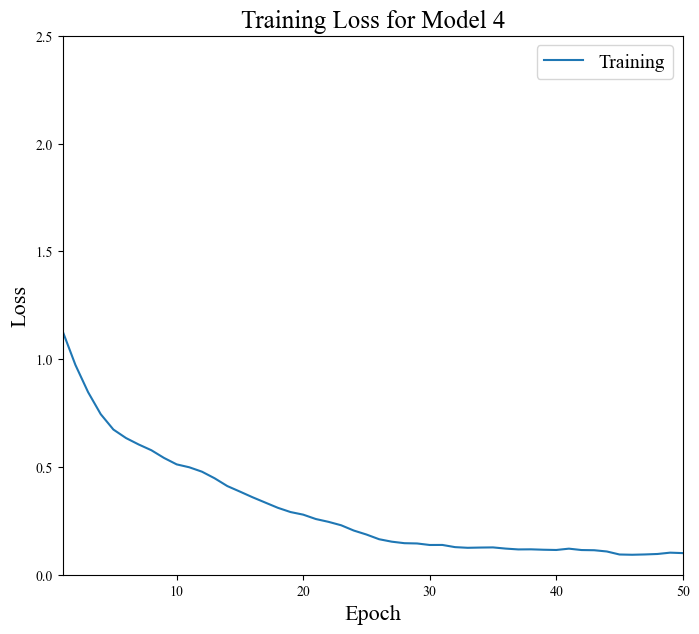

In [18]:
model_4, row_means_4 = experiment_DB_VAE(4, loader_ISIC, params_DB_VAE)
graph_loss(4, row_means_4, params_DB_VAE["num_epochs"], f"{CWD}/models/{current_time.tm_year}-{current_time.tm_mon}-{current_time.tm_mday}_model_{4}_training_loss")
model_4.save(f"{CWD}/models/{current_time.tm_year}-{current_time.tm_mon}-{current_time.tm_mday}_model_{4}.keras")
tf.keras.backend.clear_session()

Starting epoch 50/50
Recomputing the sampling probabilities


  0%|          | 0/74 [00:00<?, ?it/s]

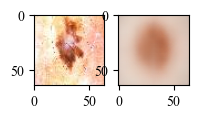

100%|██████████| 74/74 [00:06<00:00, 12.00it/s]
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/88mangos/2024-5-30-model-5/6739fc8c5fc343c8899307334ddefe4a
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [3700] : (0.05932384356856346, 6.69313907623291)
COMET INFO:   Parameters:
COMET INFO:     Adam_amsgrad                 : False
COMET INFO:     Adam_beta_1                  : 0.9
COMET INFO:     Adam_beta_2                  : 0.999
COMET INFO:     Adam_clipnorm                : None
COMET INFO:     Adam_clipvalue               : None
COMET INFO:     Adam_ema_momentum            : 0.99
COMET INFO:     Adam_ema_overwrite_frequency : None
COMET INFO:     Adam_epsi

3700
1.2056393909028644
0.954821785475129
0.8204568014506455
0.7504821611992396
0.6965014221315899
0.6552933077658737
0.6249979989808879
0.6038402815754476
0.5774344501824711
0.5488914244072983
0.5208925545694781
0.5028990164500002
0.47252660680744013
0.45466370172480625
0.43887968990458764
0.42145157709889
0.40485976674223867
0.39974921609376507
0.3853534995776602
0.3648367289761776
0.3455415570027224
0.32689441661159896
0.29651900682561666
0.27871486754765706
0.2836835889840904
0.28702546915961513
0.3322976947119683
0.304067556536268
0.27111410664436486
0.2480588512668587
0.22573035901311359
0.21179821737455126
0.19591644432868044
0.18900882681301612
0.1920506853855746
0.184161303350144
0.17829319348650347
0.17034704672519344
0.16809194462453883
0.1596636124704733
0.15793743172847646
0.14923078170260706
0.1588410623858963
0.15412567470573454
0.1506962004158595
0.15209346784383726
0.14931603152530207
0.13552940637161257
0.13152648751614268
0.1271509149936098


COMET INFO: Uploading 42 metrics, params and output messages


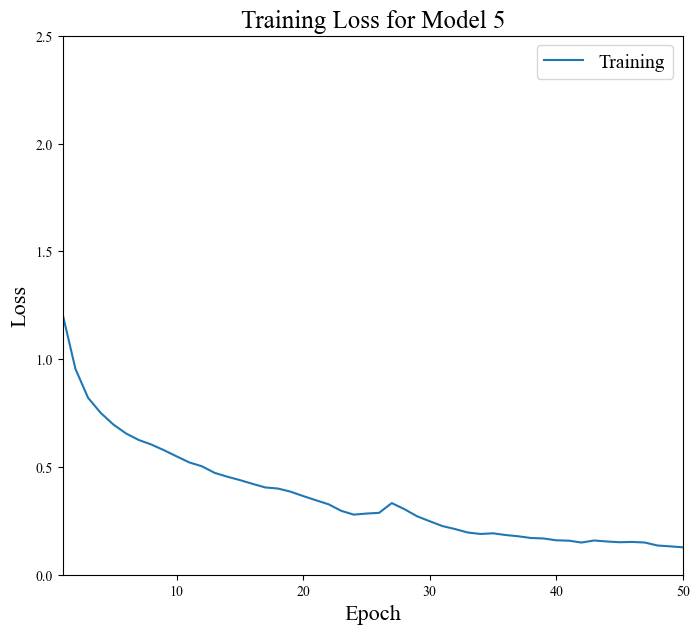

In [19]:
model_5, row_means_5 = experiment_DB_VAE(5, loader_ISIC_DiDI, params_DB_VAE)
graph_loss(5, row_means_5, params_DB_VAE["num_epochs"], f"{CWD}/models/{current_time.tm_year}-{current_time.tm_mon}-{current_time.tm_mday}_model_{5}_training_loss")
model_5.save(f"{CWD}/models/{current_time.tm_year}-{current_time.tm_mon}-{current_time.tm_mday}_model_{5}.keras")
tf.keras.backend.clear_session()

Starting epoch 50/50
Recomputing the sampling probabilities


  0%|          | 0/74 [00:00<?, ?it/s]

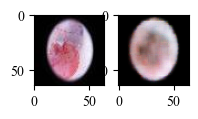

100%|██████████| 74/74 [00:06<00:00, 11.41it/s]
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/88mangos/2024-5-30-model-6/797b287c5b5047129b779fcb161c19d4
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [3700] : (0.0997096449136734, 2298024960.0)
COMET INFO:   Parameters:
COMET INFO:     Adam_amsgrad                 : False
COMET INFO:     Adam_beta_1                  : 0.9
COMET INFO:     Adam_beta_2                  : 0.999
COMET INFO:     Adam_clipnorm                : None
COMET INFO:     Adam_clipvalue               : None
COMET INFO:     Adam_ema_momentum            : 0.99
COMET INFO:     Adam_ema_overwrite_frequency : None
COMET INFO:     Adam_epsilon  

3700
1.0904622125035082
0.9506693179868067
0.8768620001576414
0.8299801445895393
0.792344538887237
0.7501616440879577
0.7025338412739236
0.6763763277886555
0.6484531533898039
0.6191749600829956
0.5993305005454362
0.5810041216904739
0.566150664773887
0.5426104892026012
0.525477961524406
0.5162815517296858
0.5109237901859561
0.5024801722712079
0.48797863443247724
0.4721112776906323
1817298.8277708557
15339534.875859866
7291495.898180672
3465940.2987449807
1647500.4989573169
783123.2570101011
372250.1362508631
176945.66911242713
84109.63033464062
39980.93262178275
19004.808307457588
9034.001291708502
4294.472292233673
2041.5756802156593
970.6606768568961
461.6167819505843
219.6417009574564
104.61841765073379
49.9570117111879
23.938870126593063
11.559432485529882
5.675178110443666
2.8793364527449574
1.5398415355646804
0.9021803909246213
0.5825497840159718
0.432505135797601
0.35977653001454624
0.31676119387294344
0.3018230455121915


COMET INFO: Uploading 42 metrics, params and output messages


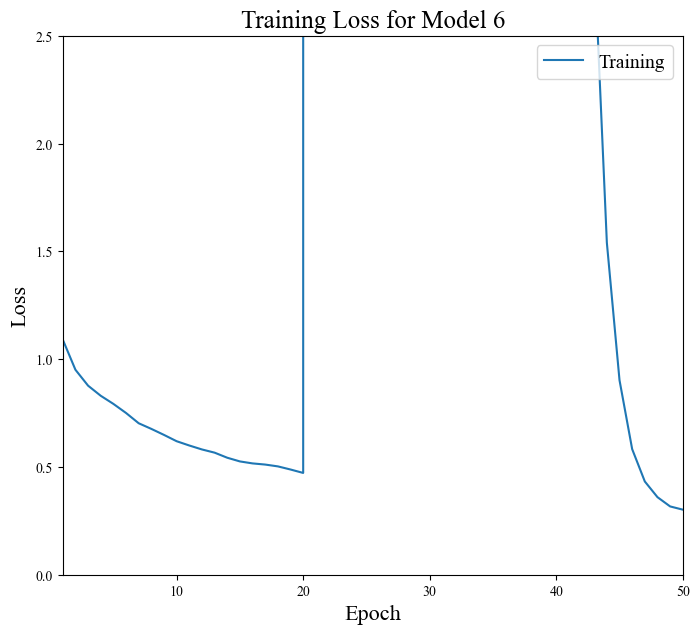

In [20]:
model_6, row_means_6 = experiment_DB_VAE(6, loader_ISIC_ArGI, params_DB_VAE)
graph_loss(6, row_means_6, params_DB_VAE["num_epochs"], f"{CWD}/models/{current_time.tm_year}-{current_time.tm_mon}-{current_time.tm_mday}_model_{6}_training_loss")
model_6.save(f"{CWD}/models/{current_time.tm_year}-{current_time.tm_mon}-{current_time.tm_mday}_model_{6}.keras")
tf.keras.backend.clear_session()

In [ ]:
### Deprecated Automated Training ###
# for i in range(1,7):
#     if (i % 3 == 1):
#         loader = loader_ISIC
#         validation_loader = loader_val_ISIC
#     elif (i % 3 == 2):
#         loader = loader_ISIC_DiDI
#         validation_loader = loader_val_ISIC_DiDI
#     elif (i % 3 == 0):
#         loader = loader_ISIC_ArGI
#         validation_loader = loader_val_ISIC_ArGI
    
#     if (i <= 3):
#         model, row_means, completed_epochs = experiment_base_CNN(i, loader, params_CNN, validation_loader) # with early stopping
#         graph_loss(i, row_means, completed_epochs)
#         #model, row_means = experiment_base_CNN(i, loader, params_CNN)
#         #graph_loss(i, row_means, params_CNN["num_epochs"])
#     elif (i <= 6):
#         model, row_means = experiment_DB_VAE(i, loader, params_DB_VAE)
#         graph_loss(i, row_means, params_DB_VAE["num_epochs"])
    
#     model.save(f"{CWD}/models/{current_time.tm_year}-{current_time.tm_mon}-{current_time.tm_mday}_model_{i}.keras")
#     tf.keras.backend.clear_session()

In [21]:
### Detail Model Training Parameters ###

end_time = time.localtime(time.time())

f = open(f"{CWD}/models/MODEL_INFO.txt", "a")
f.write(f"Start Time: {current_time.tm_year}/{current_time.tm_mon}/{current_time.tm_mday}, {current_time.tm_hour}:{current_time.tm_min}:{current_time.tm_sec}\n")
f.write('\n')
f.write("params_CNN = {\n")
f.write(f'    batch_size = {params_CNN["batch_size"]}\n')
f.write(f'    num_epochs = {params_CNN["num_epochs"]}\n')
f.write(f'    learning_rate = {params_CNN["learning_rate"]}\n')
f.write(f'    min_lr = {params_CNN["min_lr"]}\n')
f.write(f'    factor = {params_CNN["factor"]}\n')
f.write(f'    patience_lr = {params_CNN["patience_lr"]}\n')
f.write(f'    patience_stop = {params_CNN["patience_stop"]}\n')
f.write('}\n')
f.write('\n')
f.write("params_DB_VAE = {\n")
f.write(f'    batch_size = {params_DB_VAE["batch_size"]}\n')
f.write(f'    num_epochs = {params_DB_VAE["num_epochs"]}\n')
f.write(f'    learning_rate = {params_DB_VAE["learning_rate"]}\n')
f.write(f'    latent_dim = {params_DB_VAE["latent_dim"]}\n')
f.write('}\n')
f.write('\n')
f.write(f"End Time: {end_time.tm_year}/{end_time.tm_mon}/{end_time.tm_mday}, {end_time.tm_hour}:{end_time.tm_min}/{end_time.tm_sec}")
f.close()

## Research Ethics
This code makes use of the mitdeeplearning package (Amini, 2024) for the data loading function. 
The DB-VAE for Models 4-6 is inspired by the Debiasing Computer Vision Lab notebook from 6.S191.

### Copyright 2024 MIT 6.S191 Introduction to Deep Learning. All Rights Reserved. 
 
Licensed under the MIT License. You may not use this file except in compliance 
with the License. Use and/or modification of this code outside of 6.S191 must 
reference: 

© MIT 6.S191: Introduction to Deep Learning 
http://introtodeeplearning.com 